# BINF GU 4002: Machine Learning for Healthcare, Spring 2025
# Assignment \#2: Regularization and Model Selection
## DUE: 11:59 PM, Tuesday, March 11, 2025

This assignment explores regularization and model selection. We will use ideas explored in class and build intuition around how to select appropriate modelling techniques for the specific data and task you have. As an illustrative example, you will be using embeddings generated from a large-scale protein language model to predict the structural effects of a mutation in the protein sequence.

**<font color="red">Instructions: Please run the notebook using Google Colab to prevent any dependency / package issues. Make sure that your written answers are formatted using </font>$\LaTeX$<font color="red"> in `markdown` cells. When submitting, please name your files `{UNI}_binf4002_mlhc_assignment_2.{filetype}` and submit a `.ipynb` version of your Jupyter notebook. Additionally, we will render the jupyter notebook using nbviewer (https://nbviewer.org/). When you are submitting your final version, upload your homework to a public github repository and paste the github link to nbviewer and obtain the final rendered link </font>**

Link to github repository: https://github.com/clingunis/Chris_Lingunis_BINF4002_MLHC/blob/main/Assignment2/cal2288_binf4002_mlhc_assignment_2%20(3).ipynb

Link to nbviewer render:https://nbviewer.org/github/clingunis/Chris_Lingunis_BINF4002_MLHC/blob/main/Assignment2/cal2288_binf4002_mlhc_assignment_2%20%283%29.ipynb

#### The Problem and Data

We will be using data from the [Envision](https://pmc.ncbi.nlm.nih.gov/articles/pmid/29226803/) paper (Gray et al.2018). The goal is to perform variant effect prediction, where variants of β-Lactamase are created by through single-residue mutations (one amino-acid is replaced by another amino-acid in the protein sequence). The data is generated using a method called deep mutational scan.

From Gray et al. 2018:

> In a deep mutational scan, selection for protein function among a library of nearly all possible single amino acid variants of a protein is coupled to high-throughput DNA sequencing (Fowler and Fields, 2014; Fowler et al., 2014). Sequencing reveals how each variant’s frequency changes during selection, yielding quantitative scores that describe the functional effect of each variant in the library. A large-scale mutagenesis dataset contains deep and unbiased information, capturing the effects of most variants at every position in a single protein. We hypothesize that large-scale mutagenesis datasets contain informative and generalizable patterns that can be used to predict variant effects in disparate proteins.

The prediction target is a quantitative metric known as variant effect score, which depends on the protein of interest. For example, this score may capture the severity of functional disruption.

The embeddings are generated from [ESM](https://www.nature.com/articles/s41588-023-01465-0), a large-scale language (foundation) model for protein sequences developed by Meta AI. The repository can be found here: https://github.com/facebookresearch/esm/tree/main  

In [1]:
# STARTER CODE
!pip install git+https://github.com/facebookresearch/esm.git
!curl -O https://dl.fbaipublicfiles.com/fair-esm/examples/P62593_reprs.tar.gz
!tar -xzf P62593_reprs.tar.gz
!curl -O https://dl.fbaipublicfiles.com/fair-esm/examples/P62593.fasta
!pwd
!ls

FASTA_PATH = "/content/P62593.fasta" # Path to P62593.fasta
EMB_PATH = "/content/P62593_reprs" # Path to directory of embeddings for P62593.fasta
EMB_LAYER = 34

  Cloning https://github.com/facebookresearch/esm.git to /tmp/pip-req-build-9579xae8
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/esm.git /tmp/pip-req-build-9579xae8
  Resolved https://github.com/facebookresearch/esm.git to commit 2b369911bb5b4b0dda914521b9475cad1656b2ac
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for fair-esm: filename=fair_esm-2.0.1-py3-none-any.whl size=105419 sha256=e24eeb300b81086d1165b10b015a81704fbf7b267cbe04d8eaab3cf30f707ea8
  Stored in directory: /tmp/pip-ephem-wheel-cache-dk89erfd/wheels/73/b8/59/2a3415340d3dec5ae3d9ce69f8d7eb22674be68a4402b39f7a
Successfully built fair-esm
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 24.5M  100 24.5M    0     0   9.9M      0  0:00:02  0:00:02 --:--:--  9.9M
 

In [2]:
import random
from collections import Counter
from tqdm import tqdm

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import scipy
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.decomposition import PCA

import esm

ys = []
Xs = []

for header, _seq in esm.data.read_fasta(FASTA_PATH):
    scaled_effect = header.split('|')[-1]
    ys.append(float(scaled_effect))
    fn = f'{EMB_PATH}/{header}.pt'
    embs = torch.load(fn)
    Xs.append(embs['mean_representations'][EMB_LAYER])

Xs = torch.stack(Xs, dim=0).numpy()

train_size = 0.8
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, ys, train_size=train_size, random_state=42)

print(Xs.shape)
print(Xs)

<ipython-input-2-4ae02c448350>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embs = torch.load(fn)


(5397, 1280)
[[-1.9424131  -0.24231845  0.2781383  ...  0.8565104  -0.36620235
   0.37129015]
 [-1.9424131  -0.24231845  0.2781383  ...  0.8565104  -0.36620235
   0.37129015]
 [-1.9424131  -0.24231845  0.2781383  ...  0.8565104  -0.36620235
   0.37129015]
 ...
 [-1.9448644  -0.23536     0.29208067 ...  0.8340563  -0.38870698
   0.34810168]
 [-1.9425157  -0.2576361   0.25755125 ...  0.8237811  -0.3292744
   0.377921  ]
 [-1.9429678  -0.16627568  0.28286734 ...  0.8132526  -0.3705568
   0.3622785 ]]


Note for myself: The X matrix represents an array of sequencing embeddings for each sample where a different mutation is created. The y (what we are trying to predict) is the variant effect score.

#### Data exploration

Note that the embeddings are high-dimensional. To qualitatively analyse if there are patterns (ex. naturally-forming clusters) in the data, we can visualize the data using dimensionality reduction. The color indicates the level of functional distruption in the protein, and each point represents a different amino-acid sequence containing a specific mutation.

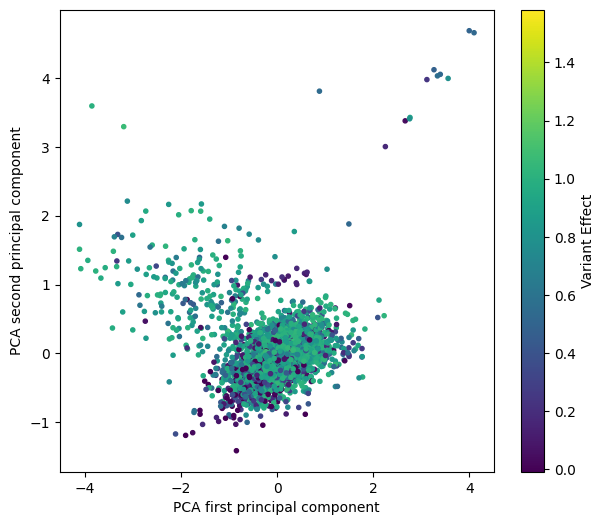

In [3]:
num_pca_components = 60
pca = PCA(num_pca_components)
Xs_train_pca = pca.fit_transform(Xs_train)

fig_dims = (7, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sc = ax.scatter(Xs_train_pca[:,0], Xs_train_pca[:,1], c=ys_train, marker='.')
ax.set_xlabel('PCA first principal component')
ax.set_ylabel('PCA second principal component')
plt.colorbar(sc, label='Variant Effect')
plt.show()

It seems only one prominent cluster emerges, with some outliers.

## [30 Points] Question 1: Bias Variance Tradeoff

Modeling data in healthcare is often in a data-constrained setting, where we may be restricted to high dimensional data with limited samples due to costs of experimentation and data acquisition. However, a key desiderata for our models is the ability to generalize to unseen samples.

How do we know if we have enough data for a given modelling task to achieve generalization? How do we choose the right modeling strategy? We will explore these questions using a phenomenon in machine learning known as the bias-variance tradeoff.

Consider a dataset $$D = \{(x_1, y_1), (x_2, y_2), ..., (x_n, y_n) \}$$

and suppose that the relationship between $x \in \mathbb{R}^1$ and $y \in \mathbb{R}^1$ values are specified by an unknown true underlying function as $y = f(x) + \epsilon$ where $\epsilon \sim N(0, \sigma^2)$.

Now, suppose we have trained an approximation of the underlying true function using the training dataset with $\hat{y} = \hat{f}(x)$, where $\hat{y}$ corresponds to the prediction of $y$

#### [15 Points] 1.1: Prove the bias-variance decomposition of mean squared error
$$\mathbb{E}_{D} \left[(y - \hat{f}(x) )^2\right] = \underbrace{\left(\mathbb{E}\left[\hat{f}(x) \right] - f(x) \right)^2}_{Bias^2} + \underbrace{\mathbb{E}_{D}\left[\left(\hat{f}(x) - \mathbb{E}\left[\hat{f}(x)\right] \right)^2 \right]}_{Variance}$$

We begin our proof with the initial line:

$$\mathbb{E}_{D} \left[(y - \hat{f}(x) )^2\right]$$

Let us plug in our formula for y.

$$=\mathbb{E}_{D} \left[(f(x)+ϵ - \hat{f}(x) )^2\right]$$

Use the associative property to rearrange terms before evaluating the square (FOIL).

$$=\mathbb{E}_{D}\left[((f(x)- \hat{f}(x))+ϵ  )^2\right]$$

$$=\mathbb{E}_{D}\left[(f(x)- \hat{f}(x))^2+ 2(f(x)- \hat{f}(x))(ϵ) +ϵ^2  \right]$$

Now apply the expectation $\mathbb{E}_{D}$ to each term. Note that the expectation (mean of the normal distribution) of $\epsilon$ is 0. Any expectations containing $\epsilon$ as a factor will become 0 except $\mathbb{E}_D[\epsilon^2]$. This is due to the fact that $\mathbb{E}_{D} [\epsilon^2]=\text{Var}(\epsilon)+\mathbb{E}_{D}^2[\epsilon]=\sigma^2+0=\sigma^2$.
$$=\mathbb{E}_{D}[(f(x)- \hat{f}(x))^2]+ \mathbb{E}_{D}[2(f(x)- \hat{f}(x))(ϵ)] +\mathbb{E}_{D}[ϵ^2] $$

$$=\mathbb{E}_{D}[(f(x)- \hat{f}(x))^2]+ 0 +\sigma^2 $$

$$=\mathbb{E}_{D}[(f(x)- \hat{f}(x))^2]+\sigma^2$$

Now we have a similar expression to what we started with in the MSE but in terms of $f(x)$ instead of $y$. We must now solve this expectation. For the sake of simplicity, $\sigma^2$ will be ignored for the derivation of the new expectation and will be added at the end.

Note that we can add and subtract $\mathbb{E}[\hat {f}(x)]$ to the inner term while keeping the expression equivalent.

$$=\mathbb{E}_{D} \left[(f(x) -\mathbb{E}[\hat {f}(x)] + \mathbb{E}[\hat {f}(x)]- \hat{f}(x) )^2\right]$$

Use the associative property to group our new terms before evaluating the square (FOIL).

$$=\mathbb{E}_{D} \left[((f(x) -\mathbb{E}[\hat {f}(x)]) + (\mathbb{E}[\hat {f}(x)]- \hat{f}(x)) )^2\right]$$

$$=\mathbb{E}_{D}\left[(f(x)-\mathbb{E}[\hat {f}(x)])^2-2(f(x)-\mathbb{E}[\hat {f}(x)])(\mathbb{E}[\hat {f}(x)]- \hat{f}(x))+(\mathbb{E}[\hat {f}(x)]- \hat{f}(x))^2\right]$$

Now we use linearity of expectation to apply $\mathbb{E}_{D}$ to each term.

$$=\mathbb{E}_{D}[(f(x)-\mathbb{E}[\hat {f}(x)])^2]-\mathbb{E}_{D}[2(f(x)-\mathbb{E}[\hat {f}(x)])(\mathbb{E}[\hat {f}(x)]- \hat{f}(x))]+\mathbb{E}_{D}[(\mathbb{E}[\hat {f}(x)]- \hat{f}(x))^2]$$

By factoring out $(-1)^2$ from the third term, we actually already have the variance factor of our final formula.

$$=\mathbb{E}_{D}[(f(x)-\mathbb{E}[\hat {f}(x)])^2]-\mathbb{E}_{D}[2(f(x)-\mathbb{E}[\hat {f}(x)])(\mathbb{E}[\hat {f}(x)]- \hat{f}(x))]+\mathbb{E}_{D}[(\hat{f}(x)-\mathbb{E}[\hat {f}(x)])^2]$$

Now, let us evaluate the first two terms.

Expand the first term's square by FOIL.

$$\mathbb{E}_{D}[(f(x)-\mathbb{E}[\hat {f}(x)])^2]=\mathbb{E}_{D}[f(x)^2-2f(x)\mathbb{E}[\hat {f}(x)]+\mathbb{E}[\hat {f}(x)]^2]$$

Apply the expectation to each term.

$$=\mathbb{E}_{D}[f(x)^2]-2\mathbb{E}_{D}[f(x)]\mathbb{E}[\hat {f}(x)]+\mathbb{E}_{D}[\mathbb{E}[\hat {f}(x)]^2]$$

We note here that f(x) is not a random function or a random variable. It is fixed and deterministic. Thus, $\mathbb{E}_{D}[f(x)]=f(x)$. We also note that $\mathbb{E}_{D}[\mathbb{E}[\hat{f}(x)]]=\mathbb{E}[\hat{f}(x)]$ since $\mathbb{E}[\hat{f}(x)]$ should also be a fixed value. We can evaluate our expectations further with these notions.

$$=f(x)^2-2f(x)\mathbb{E}[\hat{f}(x)]+\mathbb{E}[\hat{f}(x)]^2$$

We can factor this expression as follows:
$$=(\mathbb{E}[\hat{f}(x)]-f(x))^2$$

Note that this is the bias^2 term that we will need in the final formula.

Now let's go back and evaluate the second term of our overall formula.

$$-\mathbb{E}_{D}[2(f(x)-\mathbb{E}[\hat {f}(x)])(\mathbb{E}[\hat {f}(x)]- \hat{f}(x))]=-2\mathbb{E}_{D}[(f(x)-\mathbb{E}[\hat {f}(x)])(\mathbb{E}[\hat {f}(x)]- \hat{f}(x))]$$

Expand the inner polynomial by FOIL.

$$=-2\mathbb{E}_{D}[f(x)\mathbb{E}[\hat{f}(x)]-f(x)\hat{f}(x)-\mathbb{E}[\hat{f}(x)]^2+\mathbb{E}[\hat{f}(x)]\hat{f}(x)]$$

Apply the expectation to each term.

$$=-2[\mathbb{E}_{D}[f(x)\mathbb{E}[\hat{f}(x)]]-\mathbb{E}_{D}[f(x)\hat{f}(x)]-\mathbb{E}_{D}[\mathbb{E}[\hat{f}(x)]^2]+\mathbb{E}_{D}[\mathbb{E}[\hat{f}(x)]\hat{f}(x)]]$$

Evaluate with the same notions $\mathbb{E}_{D}[f(x)]=f(x)$ and $\mathbb{E}_{D}[\mathbb{E}[\hat{f}(x)]]=\mathbb{E}[\hat{f}(x)]$.

$$=-2[f(x)\mathbb{E}[\hat{f}(x)]-f(x)\mathbb{E}[\hat{f}(x)]-\mathbb{E}[\hat{f}(x)]^2+\mathbb{E}[\hat{f}(x)]^2]$$

$$=-2[0]=0$$

Plugging back into the overall equation, we have:

$$=(\mathbb{E}[\hat{f}(x)]-f(x))^2+0+\mathbb{E}_{D}[(\hat{f}(x)-\mathbb{E}[\hat {f}(x)])^2]$$

$$=(\mathbb{E}[\hat{f}(x)]-f(x))^2+\mathbb{E}_{D}[(\hat{f}(x)-\mathbb{E}[\hat {f}(x)])^2]$$

Don't forget we must add back a $\sigma^2$ term.
$$=(\mathbb{E}[\hat{f}(x)]-f(x))^2+\mathbb{E}_{D}[(\hat{f}(x)-\mathbb{E}[\hat {f}(x)])^2]+\sigma^2$$

This is equivalent to the overall bias-variance decomposition of MSE as required.

#### [5 Points] 1.2: What does it mean for the prediction model $\hat{f}(x)$ to have high bias? What are potential causes of high bias?

The prediction model having high bias means that the expectation prediction of the model predictions is far from the ground truth. In other words, the model may have very low variance and produce very consistent predictions, but having high bias would make those consistent predictions far from the ground truth. In a setting where bias and variance are analagous to accuracy and precision, high bias means low accuracy. Our decomposition formula being a sum that adds to a constant also implies that if bias is relatively high, variance must be relatively low.

Some potential causes of high bias may be training data that is not representative of the overall population, underfitting a model to training data (representative or not), or generally making incorrect/too many assumptions about the data when generating the model.

#### [5 Points] 1.3: What does it mean for the model to have high variance? What are potential causes of high variance?

The prediction model having high variance means that the actual predicted labels/values are far from the expected predicted value. In other words, the actual predictions vary widely for each data point based on the expectation the model trained on. In a setting where bias and variance are analagous to accuracy and precision, high variance means low precision. Our decomposition formula implies that if variance is relatively high, bias must be relatively low.

Some potential causes of high variance tend to come from models that are overfitted or too strongly use the training data to fit their parameters. This causes the variance present in the training data to shift the model parameters and make the actual predicted values vary widely with the variance in other training data. The overall expectation of prediction may be similar, but individual data points' predictions may vary more widely with these parameters and the new data's variance.


#### [5 Points] 1.4 Can bias and variance decrease at the same time?

Under a fixed model architecture, our MSE decomposition formula implies that bias and variance cannot decrease at the same time, since they are a sum that must add to a constant value (expectation of MSE). However, it may be possible to switch model architecture (not just adjust parameters, but make different mathematical assumptions) and shift the expectation of MSE (constant value of the sum) to be lower and thus both bias and variance decrease relative to a different model. It is also always possible that an extremely rare dataset is sampled where the model happens to predict very accurately (low bias) and high precision (low variance) just by random chance. However, the realm of expectation does not allow this to hold true for bias and variance under most normal datasets. Generally, it is considered that within the same architecture, and with relatively normal (not extreme) data, bias and variance cannot decrease together.


# [30 Points] Question 2: Regularization

A model with high bias is also called "underfitting", while a model with high variance is also called "overfitting". One idea from the bias-variance tradeoff is that purposefully introducing bias may be an effective strategy in mitigating overfitting and reducing variance.

We will now explore regularization, a common strategy used to introduce bias in the model to improve generalization.

Consider a dataset $$D = \{(\textbf{x}_1, y_1), (\textbf{x}_2, y_2), ..., (\textbf{x}_n, y_n) \}$$

where now each sample contains a vector of $d$ features $\textbf{x}_i \in \mathbb{R}^{d \times 1}$

Suppose we specifiy our model to be a linear regression model. That is, we consider a model with a vector of parameters $\beta \in \mathbb{R}^{d \times 1}$ such that $y_i = \textbf{x}_i^T \beta + \epsilon $

Note that we can equivalently write the set of $n$ equations stacked together using a matrix $\textbf{X} \in \mathbb{R}^{n \times d}$ and $\textbf{y} \in \mathbb{R}^{n \times 1}$ as follows:

$$\textbf{y} = \textbf{X} \beta + \epsilon \text{ , } \quad \epsilon \sim N(0, \sigma^2 I)$$

#### [10 Points] Question 2.1: Derive the optimal solution to the L2-regularized Squared Error Loss (also known as ridge regression) given by

$$(\textbf{X}\beta - \textbf{y})^T(\textbf{X}\beta - \textbf{y}) + \lambda \beta^T\beta $$


To derive the optimal solution to the L2-regularized Squared Error Loss (aka Ridge Regression), we must take the gradient of the above formula (the L2-regularized Squared Error) with respect to $\beta$, set the gradient to 0 and solve for $\beta$. This should have a closed-form solution. We will refer to the L2-regularized Squared Error Loss simply as $L$ for loss in our derivation.

First, let us use the identity that $\nabla_{\textbf{X}} \textbf{X}^T\textbf{X}=2\textbf{X}$ and chain rule to evaluate the gradients of the first and second term.

$$\nabla_{\beta}L=\nabla_{\beta}((\textbf{X}\beta - \textbf{y})^T(\textbf{X}\beta - \textbf{y}))+\nabla_{\beta}(\lambda \beta^T\beta)$$

$$\nabla_{\beta}L=2(\textbf{X}\beta - \textbf{y})\nabla_{\beta}(\textbf{X}\beta - \textbf{y})+2\lambda\beta$$

Note that $\nabla_{\beta}\textbf{X}\beta=\textbf{X}^T$. This is due to the fact that $\textbf{X}\beta$ can be expressed as a matrix-vector multiplication (nxd times dx1, where n=data points and d=number of features) and can be written as:

 $\textbf{X}\beta=\begin{bmatrix} \sum_{i=1}^d X_{1,i}\beta_i \\
 \sum_{i=1}^d X_{2,i}\beta_i \\
 \vdots \\
 \sum_{i=1}^d X_{n,i}\beta_i \\
 \end{bmatrix}$

Taking the derivative with respect to each feature $\beta_j$ for each of the elements in this product would produce $X_{n,j}$ for each element, iterating across $j$, the features (this is equivalent to the Jacobian Matrix). This produces a pxn matrix of the flipped elements of $\textbf{X}$ which is simply $\textbf{X}^T$. To match the dimensions of the overall multiplication while preserving the derivative, we can also move $X^T$ to before the first factor.

Knowing this, we can arrive at our final gradient for ridge regression:

$$\nabla_{\beta}L=2\textbf{X}^T(\textbf{X}\beta - \textbf{y})+2\lambda\beta$$

Let's set this equal to 0 and solve for the closed-form solution of $\beta$.

$$0=2\textbf{X}^T(\textbf{X}\beta - \textbf{y})+2\lambda\beta$$

We can factor a 2 from both terms and divide both sides to remove it.

$$0=\textbf{X}^T(\textbf{X}\beta - \textbf{y})+\lambda\beta$$

Let us now expand and group the terms with $\beta$.

$$0=\textbf{X}^T\textbf{X}\beta-\textbf{X}^T\textbf{y}+\lambda\beta$$
$$\textbf{X}^T\textbf{y}=\textbf{X}^T\textbf{X}\beta+\lambda\beta$$

Note that as we group $\beta$, $\lambda$ can no longer be treated as a scalar, but rather should be represented as a product with the identity matrix, since it is being separated from the vector $\beta$ and being put into more general matrix/vector operations.
$$\textbf{X}^T\textbf{y}=(\textbf{X}^T\textbf{X}+\lambda\textbf{I})\beta$$

Now take the inverse of the factored term on both sides (we take inverses, not "divide" to cancel matrices).

$$(\textbf{X}^T\textbf{X}+\lambda\textbf{I})^{-1}\textbf{X}^T\textbf{y}=\beta$$

Note that this ordering of the inverse creates a valid overall product on the left side (dxn @ nxd @ dxn @ nx1). And this concludes our closed-form solution of the L2-regularized square error loss, as $\textbf{X}$ and $\textbf{y}$ are given by the training data and $\lambda$ is a user-inputted parameter.


#### [15 Points] Question 2.2: Build a Ridge Regression with the skeleton code below (Fill in TODOs).

#### [5 Points] Question 2.3: What do you notice in the relationship between MSE and variance as we increase the lambda parameter?

See below the plots for the answer to Q2.3.

In [4]:
class RidgeRegression:
    def __init__(self, lambda_reg=1.0):
        self.lambda_reg = lambda_reg  # Regularization parameter
        self.beta = None  # Coefficients

    def fit(self, X, y):
        """ Compute the closed-form solution for Ridge Regression. """
        n, d = X.shape
        I = np.eye(d)  # Identity matrix
        XTX = X.T @ X  # Compute X^T X
        XTy = X.T @ y  # Compute X^T y

        # XTX and XTy are already nicely computed for us
        # I is also already initialized with correct shape, pxp

        # Closed-form solution
        self.beta = np.linalg.inv(XTX + self.lambda_reg * I) @ XTy

    def predict(self, X):
        """ Predict using the learned weights. """
        return X @ self.beta

    def mse(self, y_true, y_pred):
        """ Compute Mean Squared Error (MSE). """
        return np.mean((y_true - y_pred) ** 2)

In [5]:
# Define a range of lambda values
lambdas = np.logspace(-3, 3, 30)  # From 0.001 to 1000
mse_values = []
variance_values = []

# Compute bias and variance for each lambda
for lambda_reg in lambdas:
    model = RidgeRegression(lambda_reg)
    model.fit(Xs_train, ys_train)

    predictions = model.predict(Xs_test)
    mse = np.mean((ys_test - predictions) ** 2)
    variance = np.var(predictions)

    mse_values.append(mse)
    variance_values.append(variance)

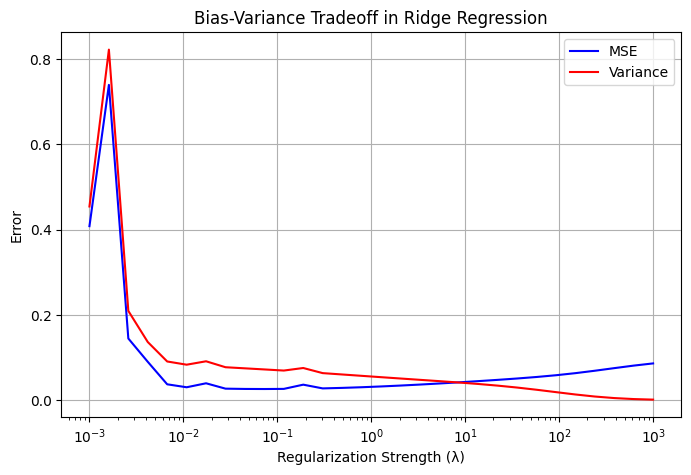

In [6]:
# Plotting Code for question 2.3

plt.figure(figsize=(8, 5))
plt.plot(lambdas, mse_values, label="MSE", color='blue')
plt.plot(lambdas, variance_values, label="Variance", color='red')
plt.xscale('log')  # Log scale for better visualization
plt.xlabel("Regularization Strength (λ)")
plt.ylabel("Error")
plt.title("Bias-Variance Tradeoff in Ridge Regression")
plt.legend()
plt.grid()
plt.show()

####Q.2.3 Answer

We see that as $\lambda$ increases, the MSE tends to decrease while the variance increases. This trend begins most notably at and after $\lambda=10^{-2}$. The intersection of MSE and variance occurs around $\lambda=10^1$. This is consistent with the bias variance tradeoff that was derived in Question 1. In this portion, the MSE approximates our loss which is a quantification of our bias. The plot confirms that as bias of the model increases (influenced by lambda), the variance of the model decreases and vice versa (centered around a constant for the model architecture, expectation of mean-squared error). As stated before, this is most noticeable after $\lambda=10^{-2}$ and continues to the rightmost $\lambda$ value on the plot.

# [20 Points] Question 3: Bayesian Variable Selection

Follwing the intuition we have built around regularization, we will now explore a more complex Bayesian model for the protein variant effect prediction task. We assume the same linear model with the same dimensionality as before

$$\textbf{y} = \textbf{X} \beta + \epsilon \text{ , } \quad \epsilon \sim N(0, \sigma^2 I)$$

However, now we will introduce a prior on the model parameters $\beta$. For each $\beta_j$ where $j=1, ..., d$, the prior takes the following form

$$ \beta_j | \gamma_j \sim (1 - \gamma_j)\cdot 0 + \gamma_j N(0, \sigma_\beta^2) \text{ , } \quad \gamma_j \sim \text{Bernoulli}(p)$$

Equivalently, we can rewrite the resulting model in a slightly more compact form where $\circ$ indicates a element-wise (hadamard) product between two vectors.

$$ \beta \sim N(0, \sigma_\beta^2) $$
$$ \textbf{y}_i | \textbf{x}_i, \beta, \gamma \sim N((\gamma \circ \beta)^T \textbf{x}_i, \sigma^2)$$


#### [5 Points] 3.1: What is the role of the $\gamma$ parameter in determining $\beta$ in the prior? What happens when $\gamma = 1$ and $\gamma = 0$?

We are given the following line defining the prior $\gamma$ on $\beta$:
$$ \beta_j | \gamma_j \sim (1 - \gamma_j)\cdot 0 + \gamma_j N(0, \sigma_\beta^2) \text{ , } \quad \gamma_j \sim \text{Bernoulli}(p)$$

We can rewrite some of these terms to more clearly see the role of $\gamma$ on $\beta$.

The above expression is equivalent to:

$$\beta_j | \gamma_j \sim \mathbf{1}(\gamma_j=0)(\beta_j|\gamma_j=0)+\mathbf{1}(\gamma_j=1)(\beta_j|\gamma_j=1)$$

This follows a format similar to a decision tree except on actual values instead of probabilities. From this expression, we can see that $(\beta_j|\gamma_j=0)=0$ we can also see that $(\beta_j|\gamma_j=1)=N(0,σ^2_\beta)$. In plain speech, what this means is that $\beta_j$ will always be 0 when $\gamma_j$ is 0 and $\beta_j$ will be distributed normally on $N(0,\sigma^2_\beta)$ only when $\gamma_j$ is 1. In other words, $\beta_j$ only has nonzero variance when $\gamma_j$ is 1 and is centered on 0 regardless.

#### [10 Points] 3.2: We would like to fit the parameters $\gamma, \beta$ using MAP estimation. Write the posterior objective $p(\gamma, \beta | \textbf{X}, \textbf{y})$ in terms of the priors and likelihoods. (We will assume $\sigma^2$ is fixed for purposes of this problem)

Hints: Recall the posterior probability we wish to maximize given data is $p(\theta | \text{X}, \text{y}) \propto p(\theta) \prod_i^n p(y_i |x_i, \theta) $. What are the distributional families of the priors and likelihoods?

First, let us write the general form of the posterior:

$$P(\gamma,\beta|\mathbf{X},\mathbf{y})=P(\mathbf{y}|\mathbf{X},\beta,\gamma)*P(\beta,\gamma|\mathbf{X})=P(\mathbf{y}|\mathbf{X},\beta,\gamma)*P(\beta,\gamma)$$

Note that the evidence denominator $P(\mathbf{y})$ is excluded from the objective function because it is constant relative to our paramaters $\beta, \gamma$ and will not effect the objective function in optimization.

We can break up the second factor using the definition of conditional probability.

$$P(\gamma,\beta|\mathbf{X},\mathbf{y})=P(\mathbf{y}|\mathbf{X},\beta,\gamma)*P(\beta|\gamma)*P(\gamma)$$

We are also given that the elements of $\mathbf{y}$, $\mathbf{y}_i$, are distributed normally on a univariate Gaussian, not a multivariate. A similar pattern occurs with the elements (features) of $\beta$, $\beta_j$. We can rewrite the posterior as products of probabilities over these indices.

$$P(\gamma,\beta|\mathbf{X},\mathbf{y})=∏_{i=1}^n P(\mathbf{y}_i|\mathbf{x}_i,\beta,\gamma)∏_{j=1}^d P(\beta_j|\gamma_j)P(\gamma_j)$$

Note that the first term $P(\mathbf{y}_i|\mathbf{x}_i,\beta,\gamma)$ is simply given by plugging in the $N((\gamma \circ \beta)^T \textbf{x}_i, \sigma^2)$ pdf.Thus, we are left with just writing $P(\beta_j|\gamma_j)P(\gamma_j)$. We note that $P(\beta_j|\gamma_j)$ actually follows two distributions depending on the value of $\gamma_j$. Since the value of $\beta_j=0$ has constant probability of 1 under $\gamma_j=0$ and $P(B_j|\gamma_j)$ follows the Gaussian $N(0,\sigma^2_\beta)$ under $\gamma_j=1$, we observe a "spike" in $P(B_j|\gamma_j)$ at $\beta_j=0$ and $\gamma_j=0$ and either 0 probability or Gaussian everywhere else. This is known as a "spike-slab" prior that we must account for in our $P(\beta_j|\gamma_j)$ term.

To fully capture this behavior, we will need a helper function $\delta (\beta_j)$ called the Dirac delta function. This functions outputs 1 when $\beta_j=0$ and 0 at all other times. This will help us capture the "spike" behavior we observe in the pdf of $\beta_j$ when $\gamma_j=0$. Now that we have a pdf for both behaviors of $\gamma_j$, we can now decompose $P(\beta_j|\gamma_j)$ into the two cases of $\gamma_j$ as follows:

$$P(\beta_j|\gamma_j)=[(1-\gamma_j)\delta(\beta_j)+\gamma_j\text{pdf}(N(0,\sigma_\beta^2))]$$

Note that this looks almost exactly like the following equation we were given except the actual values of $\beta_j$ are replaced with the respective pdfs (since we are working in probability space):

$$ \beta_j | \gamma_j \sim (1 - \gamma_j)\cdot 0 + \gamma_j N(0, \sigma_\beta^2)$$

Now, all that is left is to write the $P(\gamma_j)$ term. We are given that $\gamma_j \sim \text{Bernoulli}(p)$ so this probability is simply given by the Bernoulli pdf (that accounts for the state of $\gamma_j$). Note here that each feature $j$ and $\gamma_j$ will have its own $p_j$ after fitting. We will initialize all $p_j$ to be the same in our gradient descent.

$$P(\gamma_j)=p_j^{\gamma_j}(1-p_j)^{(1-\gamma_j)}$$

Now, let us simply plug in our terms and pdfs to get the overall objective function.

$$P(\gamma,\beta|\mathbf{X},\mathbf{y})=\prod_{i=1}^n \frac {1}{\sqrt{2\pi\sigma^2}} \text{exp}(-\frac {(\mathbf{y}_i-(\gamma \circ \beta)^T\mathbf{x}_i)^2}{2\sigma^2})\prod_{j=1}^d[(1-\gamma_j)\delta(\beta_j) +\gamma_j(\frac{1}{\sqrt{2\pi\sigma_\beta^2}}\text{exp}(-\frac{(\beta_j-0)^2}{2\sigma^2_{\beta}}))]p_j^{\gamma_j}(1-p_j)^{(1-\gamma_j)}$$

$$P(\gamma,\beta|\mathbf{X},\mathbf{y})=\prod_{i=1}^n \frac {1}{\sqrt{2\pi\sigma^2}} \text{exp}(-\frac {(\mathbf{y}_i-(\gamma \circ \beta)^T\mathbf{x}_i)^2}{2\sigma^2})\prod_{j=1}^d[(1-\gamma_j)\delta(\beta_j) +\gamma_j(\frac{1}{\sqrt{2\pi\sigma_\beta^2}}\text{exp}(-\frac{\beta_j^2}{2\sigma^2_{\beta}}))]p_j^{\gamma_j}(1-p_j)^{(1-\gamma_j)}
$$

Now, while this is technically our objective function, this looks very messy. We can clean things up a bit by taking the log objective function.

$$\log(P(\gamma,\beta|\mathbf{X},\mathbf{y}))=\sum_{i=1}^n (-\log(\sqrt{2\pi\sigma^2}) +(-\frac {(\mathbf{y}_i-(\gamma \circ \beta)^T\mathbf{x}_i)^2}{2\sigma^2}))+\sum_{j=1}^d
\\\log([(1-\gamma_j)\delta(\beta_j) +\gamma_j(\frac{1}{\sqrt{2\pi\sigma_\beta^2}}\text{exp}(-\frac{\beta_j^2}{2\sigma^2_{\beta}}))])+(\gamma_j\log(p_j)+(1-\gamma_j)\log(1-p_j))$$

This will be easier to implement in optimization, although we will not take the gradient of this and optimize in this question. We would find that the following term does not have a nice closed-form optimization solution:

$$\log([(1-\gamma_j)\delta(\beta_j) +\gamma_j(\frac{1}{\sqrt{2\pi\sigma_\beta^2}}\text{exp}(-\frac{\beta_j^2}{2\sigma^2_{\beta}}))])$$

Thus, we would need stochastic gradient descent (or a similar method) to optimize $\beta, \gamma$ (or $p$) in this objective. But we have obtained the posterior objective $p(\gamma, \beta | \textbf{X}, \textbf{y})$ in terms of priors and likelihoods as required.


#### [5 Points] 3.3: Run the code below to obtain the MAP estimate of the optimal parameters of $\gamma$. Interpret the plot. What does the posterior $p(\gamma_j = 1 | \textbf{X}, \textbf{y})$ being high or low indicate for a given $j \in \{1, ..., d\}$?

See below the plot for the answer to this portion.

In [7]:
import pymc as pm

num_features = Xs_train.shape[1]

# Bayesian model with spike-and-slab prior (note this takes around 5 minutes)
# Note that in 3.2, the expression cannot be optimized analytically with a closed form solution.
# The following code uses an iterative gradient decsent optimization procedure to find a local maximum

with pm.Model() as model:
    logit_gamma = pm.Normal("logit_gamma", mu=0, sigma=1, shape=num_features)
    gamma = pm.Deterministic("gamma", pm.math.sigmoid(logit_gamma))  # Continuous approximation of bernoulli to speed up gradient-based optimization

    beta = pm.Normal("beta", mu=0, sigma=1, shape=num_features) * gamma
    sigma = pm.HalfNormal("sigma", sigma=1) # This is a normal distribution but only takes positive values (positive half of a normal distribution)

    mu = pm.math.dot(Xs_train, beta)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=ys_train)

    map_estimate = pm.find_MAP()


Output()

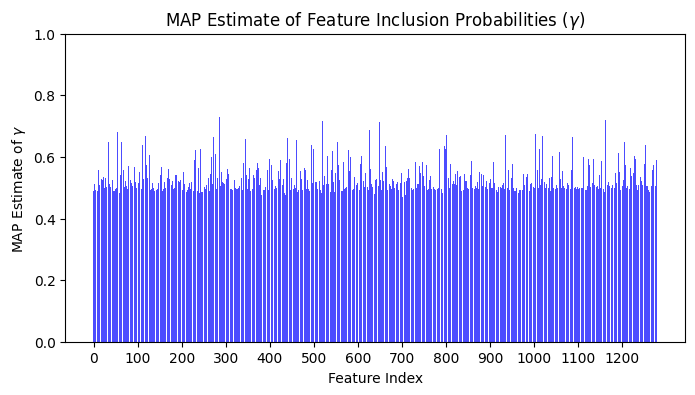

In [8]:
gamma_map = map_estimate["gamma"]

# Plot the MAP estimate of gamma
plt.figure(figsize=(8, 4))
plt.bar(np.arange(len(gamma_map)), gamma_map, color="blue", alpha=0.7)
plt.xlabel("Feature Index")
plt.ylabel("MAP Estimate of $\gamma$")
plt.title("MAP Estimate of Feature Inclusion Probabilities ($\gamma$)")
plt.xticks(np.arange(0, len(gamma_map), 100))
plt.ylim(0, 1)  # Since gamma is in (0,1)
plt.show()

#### Answer to Q3.3

The x-axis of the above plot represents the feature index $j$ e.g. feature index=100 represents the 100th feature. The y-axis of the above plot represents the posterior $P(\gamma_j=1|\mathbf{y},\mathbf{X})$ which if you remember that $\gamma_j \sim \text {Bernoulli}(p)$, you can derive that this posterior is equivalent to:

$$P(\gamma_j=1|\mathbf{y},\mathbf{X})=p_j^1(1-p_j)^0=p_j$$

Essentially, this tells us that the y-axis of the above graph is really the estimated optimal $p_j$ of $\gamma_j$ for feature $j$ that maximizes our objective. In other words, the y-axis is the optimal probability that we include the given feature $j$ under the Gaussian probability model for $\beta_j$ and not under the spike model (Dirac delta). For example, if you had a very high y-axis value ($P(\gamma_j=1|\mathbf{y},\mathbf{X})$) for a certain feature, it has a very high probability of being included under the Gaussian model for the prior on $\beta_j$. If you had a very low y-axis value ($P(\gamma_j=1|\mathbf{y},\mathbf{X})$) for a certain feature, it has a very high probability of being included under the spike model (Dirac delta) for the prior on $\beta_j$. In terms of actually choosing $\gamma_j$, this graph directly gives us the $p_j$ needed to determine $\gamma_j$ for each feature in the Bernoulli distribution. We can actually plug this directly into our objective. It seems that the mean or expectation of $p_j$ for the features is about 0.5.

# [10 Points] Question 3: Model Selection & Cross Validation

Using the intuition we have built around regularization, we will now explore practical strategies for selecting the best parameters for a model. We will use the following function to perform cross validation

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

#### [10 Points] 3.1: Define a range of parameters and number of cross validation folds. Report the best parameter and mean squared error obtained on the held-out testing data

It is given in the code comments that we are performing 3-fold cross-validation and that we are going to use sklearn's built-in Ridge Regression object. Some notes are that we must define 3-fold cross validation in GridSearchCV, ```Ridge()``` defines a ```score()``` function as $R^2$ which is not MSE that we are looking for and ```scoring``` needs to be passed to GridSearchCV as ```neg_mean_squared_error``` as the negative of MSE (regular MSE is found by positive of this value), and ```alpha``` directly represents $\lambda$ regularization parameter that we used earlier in this assignment.  

Additional documentation used:

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge.score

https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

In [10]:
# We have already validated lambda against MSE in Question 2
# We used the following evaluation set for lambda in that portion, Question 2.3.
# This may be a good baseline to evaluate lambda/alpha on in this portion.
print(np.logspace(-3,3,30))

[1.00000000e-03 1.61026203e-03 2.59294380e-03 4.17531894e-03
 6.72335754e-03 1.08263673e-02 1.74332882e-02 2.80721620e-02
 4.52035366e-02 7.27895384e-02 1.17210230e-01 1.88739182e-01
 3.03919538e-01 4.89390092e-01 7.88046282e-01 1.26896100e+00
 2.04335972e+00 3.29034456e+00 5.29831691e+00 8.53167852e+00
 1.37382380e+01 2.21221629e+01 3.56224789e+01 5.73615251e+01
 9.23670857e+01 1.48735211e+02 2.39502662e+02 3.85662042e+02
 6.21016942e+02 1.00000000e+03]


In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

# default alpha=1..0
ridge_model = Ridge()
ridge_model.fit(Xs_train, ys_train)
# Define hyperparameter grid for Ridge Regression (This is only graded on completion and not on model performance)
param_grid = {'alpha': np.logspace(-3,3,30)}

# Perform GridSearchCV with 3-fold cross-validation

# We are given that the cv needs to be 3-fold
# Default is 5-fold
num_folds=3
# refit is on by default
grid_search = GridSearchCV(ridge_model, param_grid, cv=num_folds, scoring='neg_mean_squared_error')
grid_search.fit(Xs_train, ys_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=4.09577e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=4.57121e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=4.26944e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=4.54273e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarnin

GridSearchCV(cv=3, estimator=Ridge(),
             param_grid={'alpha': array([1.00000000e-03, 1.61026203e-03, 2.59294380e-03, 4.17531894e-03,
       6.72335754e-03, 1.08263673e-02, 1.74332882e-02, 2.80721620e-02,
       4.52035366e-02, 7.27895384e-02, 1.17210230e-01, 1.88739182e-01,
       3.03919538e-01, 4.89390092e-01, 7.88046282e-01, 1.26896100e+00,
       2.04335972e+00, 3.29034456e+00, 5.29831691e+00, 8.53167852e+00,
       1.37382380e+01, 2.21221629e+01, 3.56224789e+01, 5.73615251e+01,
       9.23670857e+01, 1.48735211e+02, 2.39502662e+02, 3.85662042e+02,
       6.21016942e+02, 1.00000000e+03])},
             scoring='neg_mean_squared_error')

It sems that GridSearchCV found the best lambda/alpha to be 0.11721022975334805

In [27]:
grid_search.get_params()

{'cv': 3,
 'error_score': nan,
 'estimator__alpha': 1.0,
 'estimator__copy_X': True,
 'estimator__fit_intercept': True,
 'estimator__max_iter': None,
 'estimator__positive': False,
 'estimator__random_state': None,
 'estimator__solver': 'auto',
 'estimator__tol': 0.0001,
 'estimator': Ridge(),
 'n_jobs': None,
 'param_grid': {'alpha': array([1.00000000e-03, 1.61026203e-03, 2.59294380e-03, 4.17531894e-03,
         6.72335754e-03, 1.08263673e-02, 1.74332882e-02, 2.80721620e-02,
         4.52035366e-02, 7.27895384e-02, 1.17210230e-01, 1.88739182e-01,
         3.03919538e-01, 4.89390092e-01, 7.88046282e-01, 1.26896100e+00,
         2.04335972e+00, 3.29034456e+00, 5.29831691e+00, 8.53167852e+00,
         1.37382380e+01, 2.21221629e+01, 3.56224789e+01, 5.73615251e+01,
         9.23670857e+01, 1.48735211e+02, 2.39502662e+02, 3.85662042e+02,
         6.21016942e+02, 1.00000000e+03])},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': 'neg_mean_squared_error

In [29]:
# Ok, let's get our predictions and compute MSE

# Can get predictions from the grid_search object directly
y_preds=grid_search.predict(Xs_test)
mse=np.mean((ys_test-y_preds)**2)
print("Refitted GridSearchCV object Prediction  Test MSE: "+str(mse))

# Verify these results are consistent with manually regularizing and refitting Ridge()
ridge_model = Ridge(alpha=0.11721022975334805)
ridge_model.fit(Xs_train, ys_train)
mse=np.mean((ys_test-y_preds)**2)
print("Manually refitted and regularized Ridge() with new alpha/lambda Prediction Test MSE: "+str(mse))

# Print original MSE from unfitted lambda regularized model
ridge_model=Ridge()
ridge_model.fit(Xs_train, ys_train)
y_preds=ridge_model.predict(Xs_test)
mse=np.mean((ys_test-y_preds)**2)
print("Original alpha/lambda Test MSE: "+str(mse))

Refitted GridSearchCV object Prediction  Test MSE: 0.025912748535115195
Manually refitted and regularized Ridge() with new alpha/lambda Prediction Test MSE: 0.025912748535115195
Original alpha/lambda Test MSE: 0.031008704545679163


It seems our final, best recovered model with fitted $\beta$ and new $\lambda$ has a final MSE of 0.025912748535115195 on the test data. This is an improvement from the model where $\lambda$ was not fitted which had an MSE of 0.031008704545679163 on the test data. Our validation on regularization did indeed improve our final loss with this model. See above for the report of the optimal lambda/alpha (lambda/alpha=0.11721022975334805). We have recovered the optimal (fitted) model with new lambda/alpha reported and test MSE reported as required.